# Imperial AI & Machine Learning Capstone Project  
Submission by: **Andrew Major**  
Student Number: **432**

## 1. Problem Statement and Objective  

- **Problem**: Predict customer churn (i.e., which customers are likely to leave the bank).
- **Objective**: Develop a model that accurately predicts churn to help the bank retain valuable customers.


## 2. Initial Setup


In [1]:
import numpy as np
import pandas as pd
import decimal
from termcolor import colored
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import capstoneFunctions as cf

from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler

## 3. Data Preparation  

* **Data Collection**: Source a banking customer dataset, including features such as account balance, transaction frequency, customer demographics, etc.
* **Data Cleaning**:
  * Handle missing values (impute or drop).
  * Remove irrelevant features.
  * Check for duplicates.
* **Data Exploration**:
  * Understand the distribution of features.
  * Identify potential outliers.
### Load the dataset from .csv file  
* Explore columns and missing data

In [2]:
rawData = pd.read_csv('./data/churn_modelling.csv')

In [3]:
rawData.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
rawData.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Now look for the missing values...

In [5]:
np.where(pd.isnull(rawData))

(array([], dtype=int64), array([], dtype=int64))

We can drop any irrelevant columns unlikely to influence outcome...

In [6]:
rawData = rawData.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

## 5. Data Preprocessing  

* **Feature Scaling**: Normalise numerical features (e.g., using Min-Max scaling or Z-score normalisation). After consultation, it was agreed to only scale features for the K-Nearest Neighbours model.
* **Handling Categorical Features**:
  * Convert categorical features to numerical using one-hot encoding.
* **Feature Engineering**:
  * Consider creation of new features if relevant (e.g., customer tenure, transaction frequency).
  * Explore interactions between features.

In [7]:
encodedData = pd.get_dummies(rawData,drop_first=True)
encodedData

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


Split the data into predictors and outcomes, in preparation for creation of training, test and validation sets

In [8]:
predictors = encodedData.drop(columns=['Exited'])
outcomes = encodedData['Exited']

Check the distribution of outcomes, as this will influence our choice of performance metrics for the models later.

In [9]:
outcomes.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

The target of positive churn represents approximately 20% of the total dataset; this imbalance means we will lean towards the F1 Score as a performance metric as it is impacted by both precision and recall.

### Plot Correlation Matix  
* We need to determine if multi-colinearity will be an issue

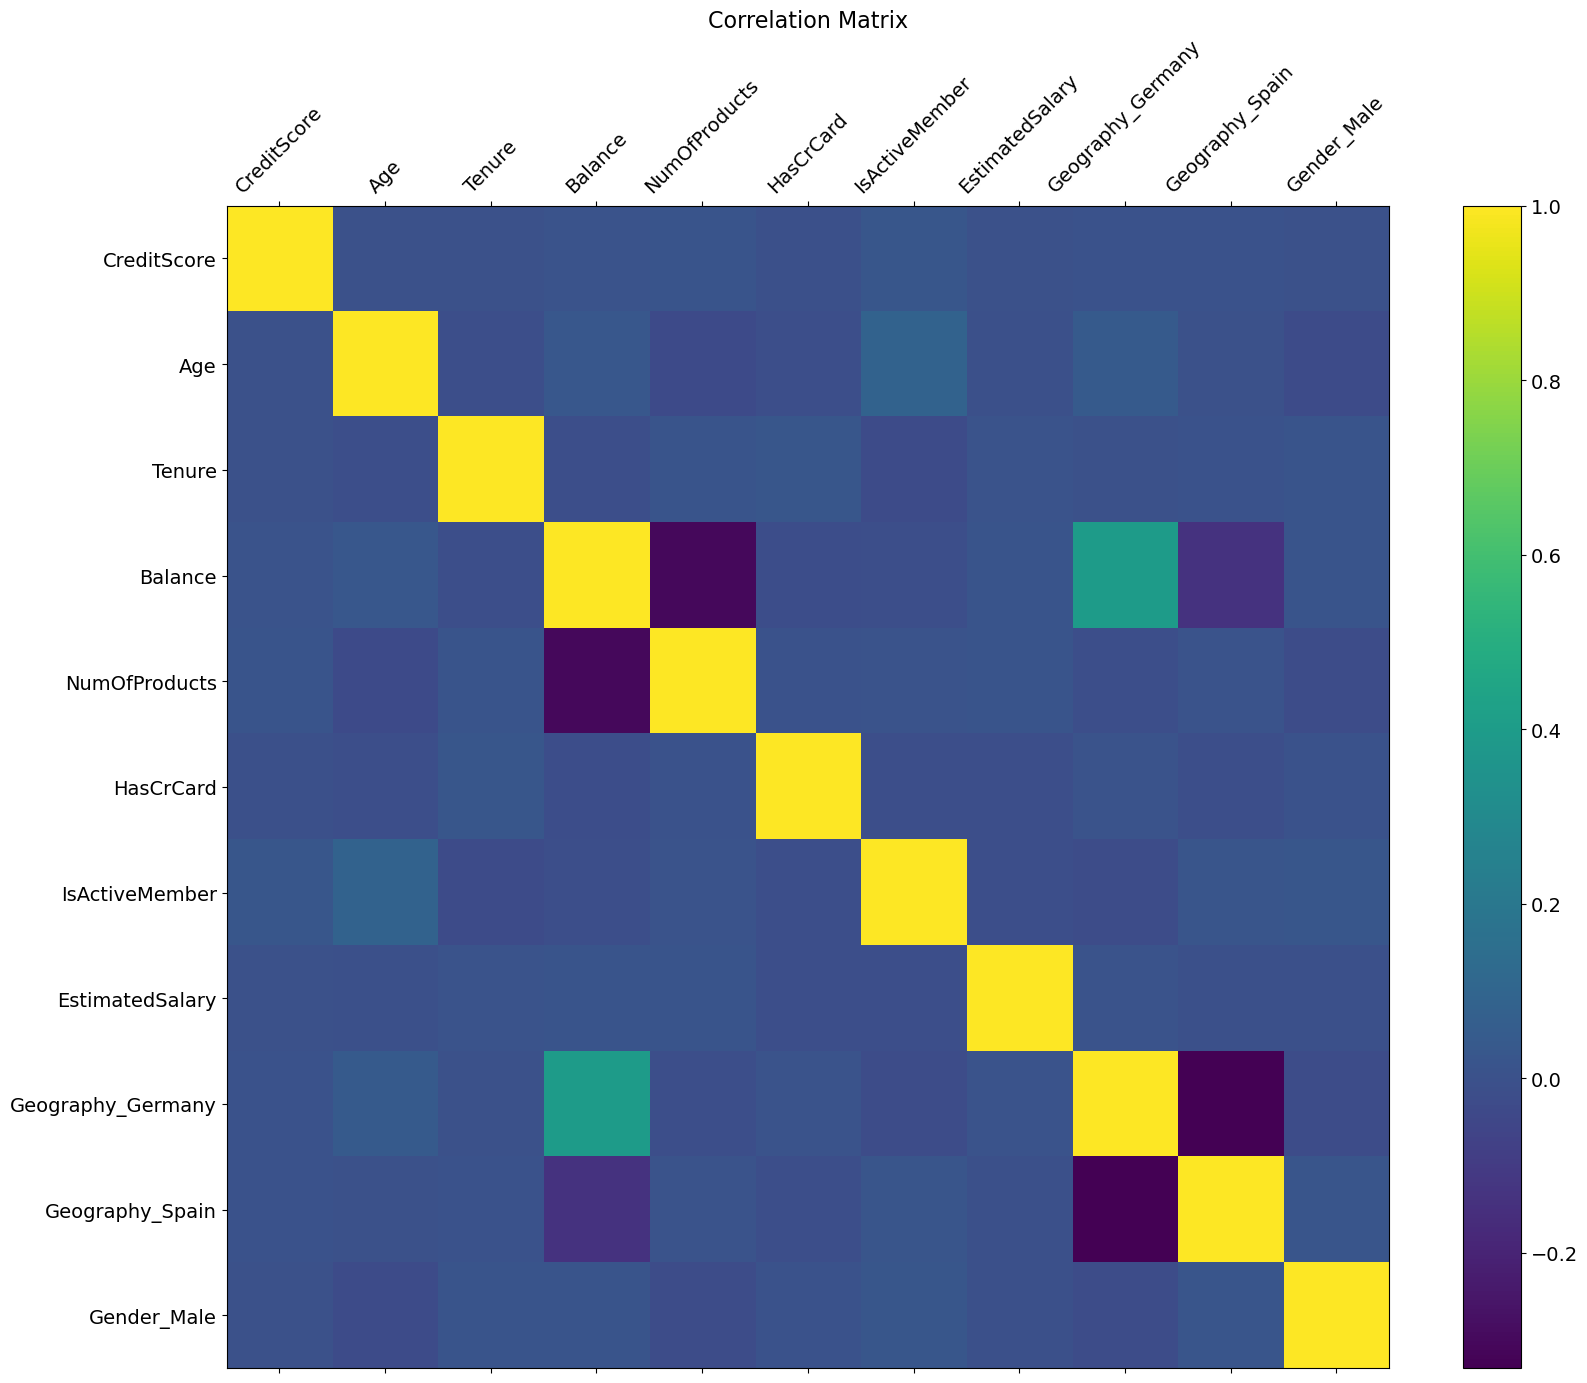

In [10]:
cf.correlationMatrix(predictors)

We can see from the matrix that the only significant correlation is between Balance and Geography_Germany features; we will recreate the dataset including Geography_France in place of Geography_Germany (excluded by drop_first=true) and re-check correlations.

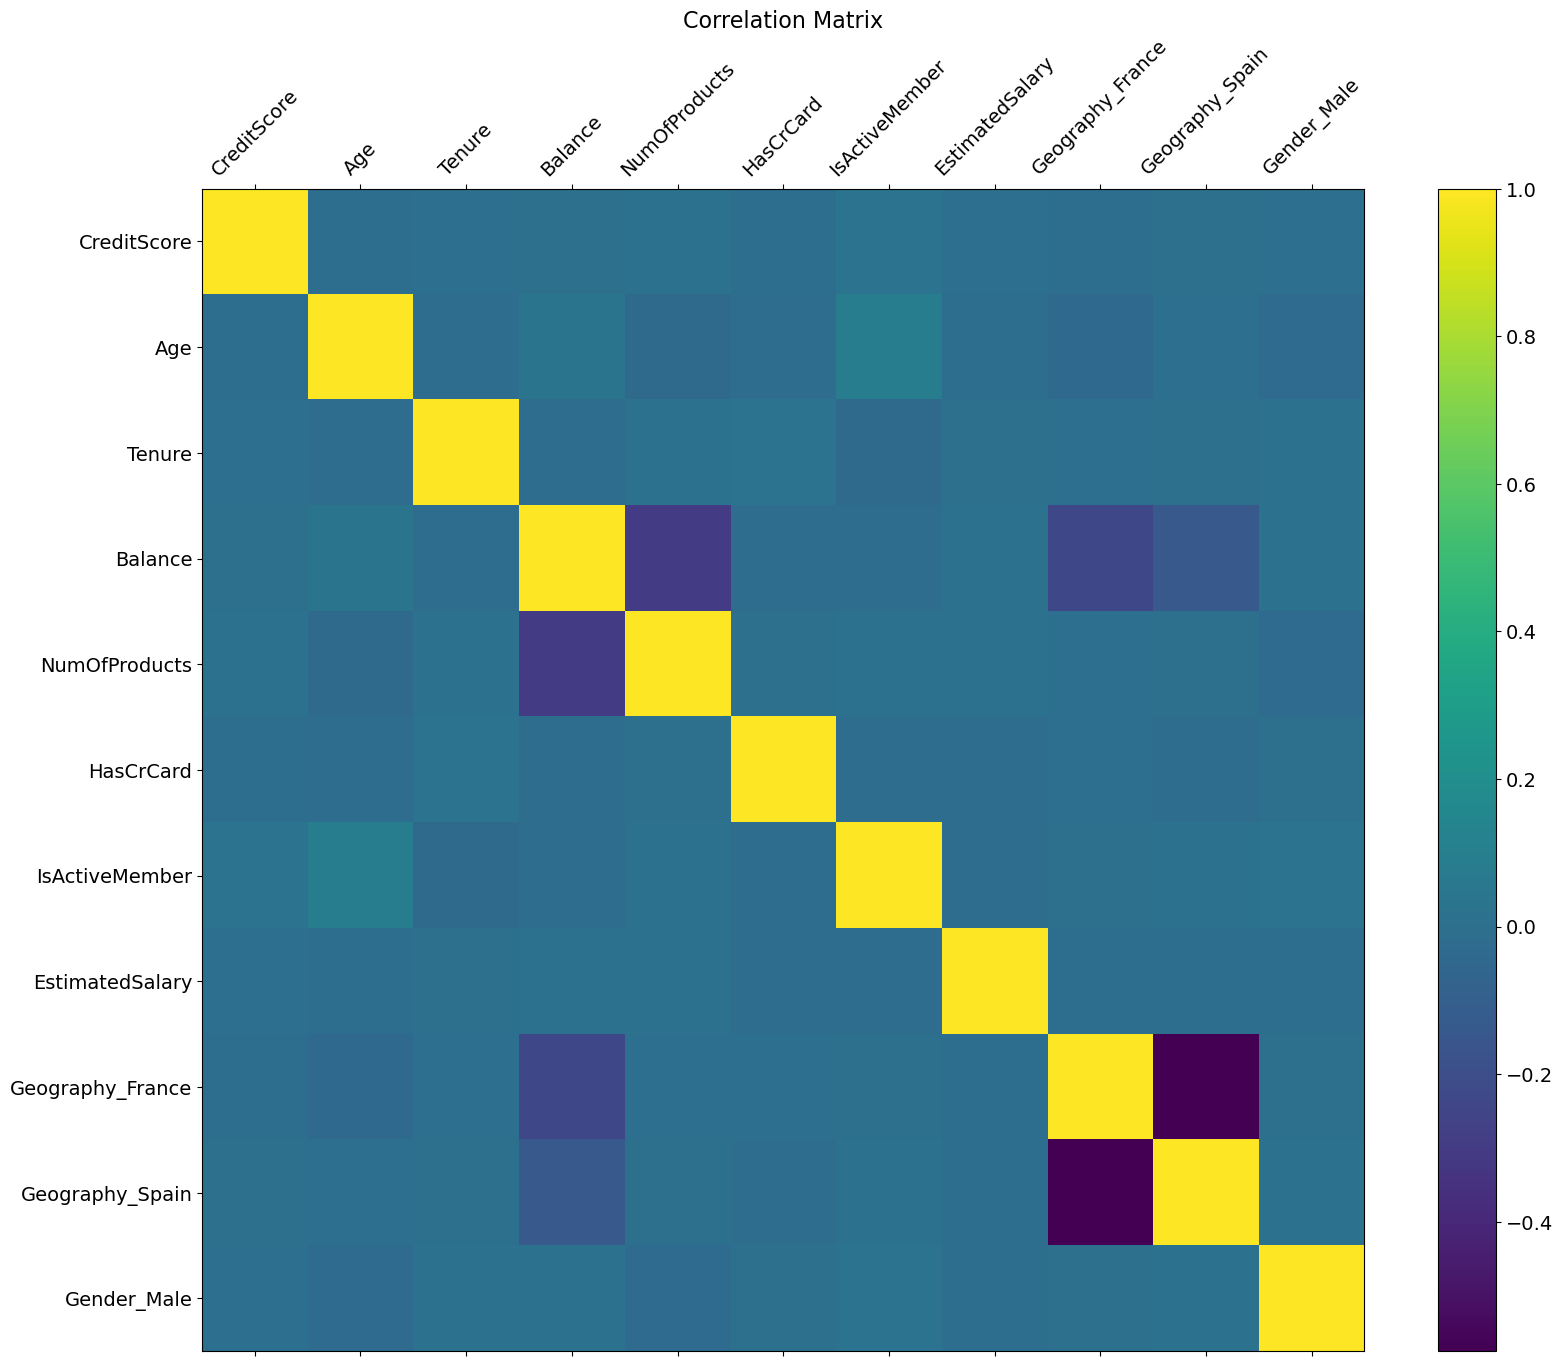

In [11]:
encodedData = pd.get_dummies(rawData)
encodedData.drop(columns=['Geography_Germany', 'Gender_Female'], inplace=True)
predictors = encodedData.drop(columns=['Exited'])
outcomes = encodedData['Exited']
cf.correlationMatrix(predictors)

That initially looks better, and we have not lost any Geographical data! However,multiple time-consuming attempts at optimisation yielded very poor results overall for every model under trial. It is possible that the negative correlations still yielding for Geography_France and Geography_Spain with Balance might be having an effect; we will try eliminating them altogether.

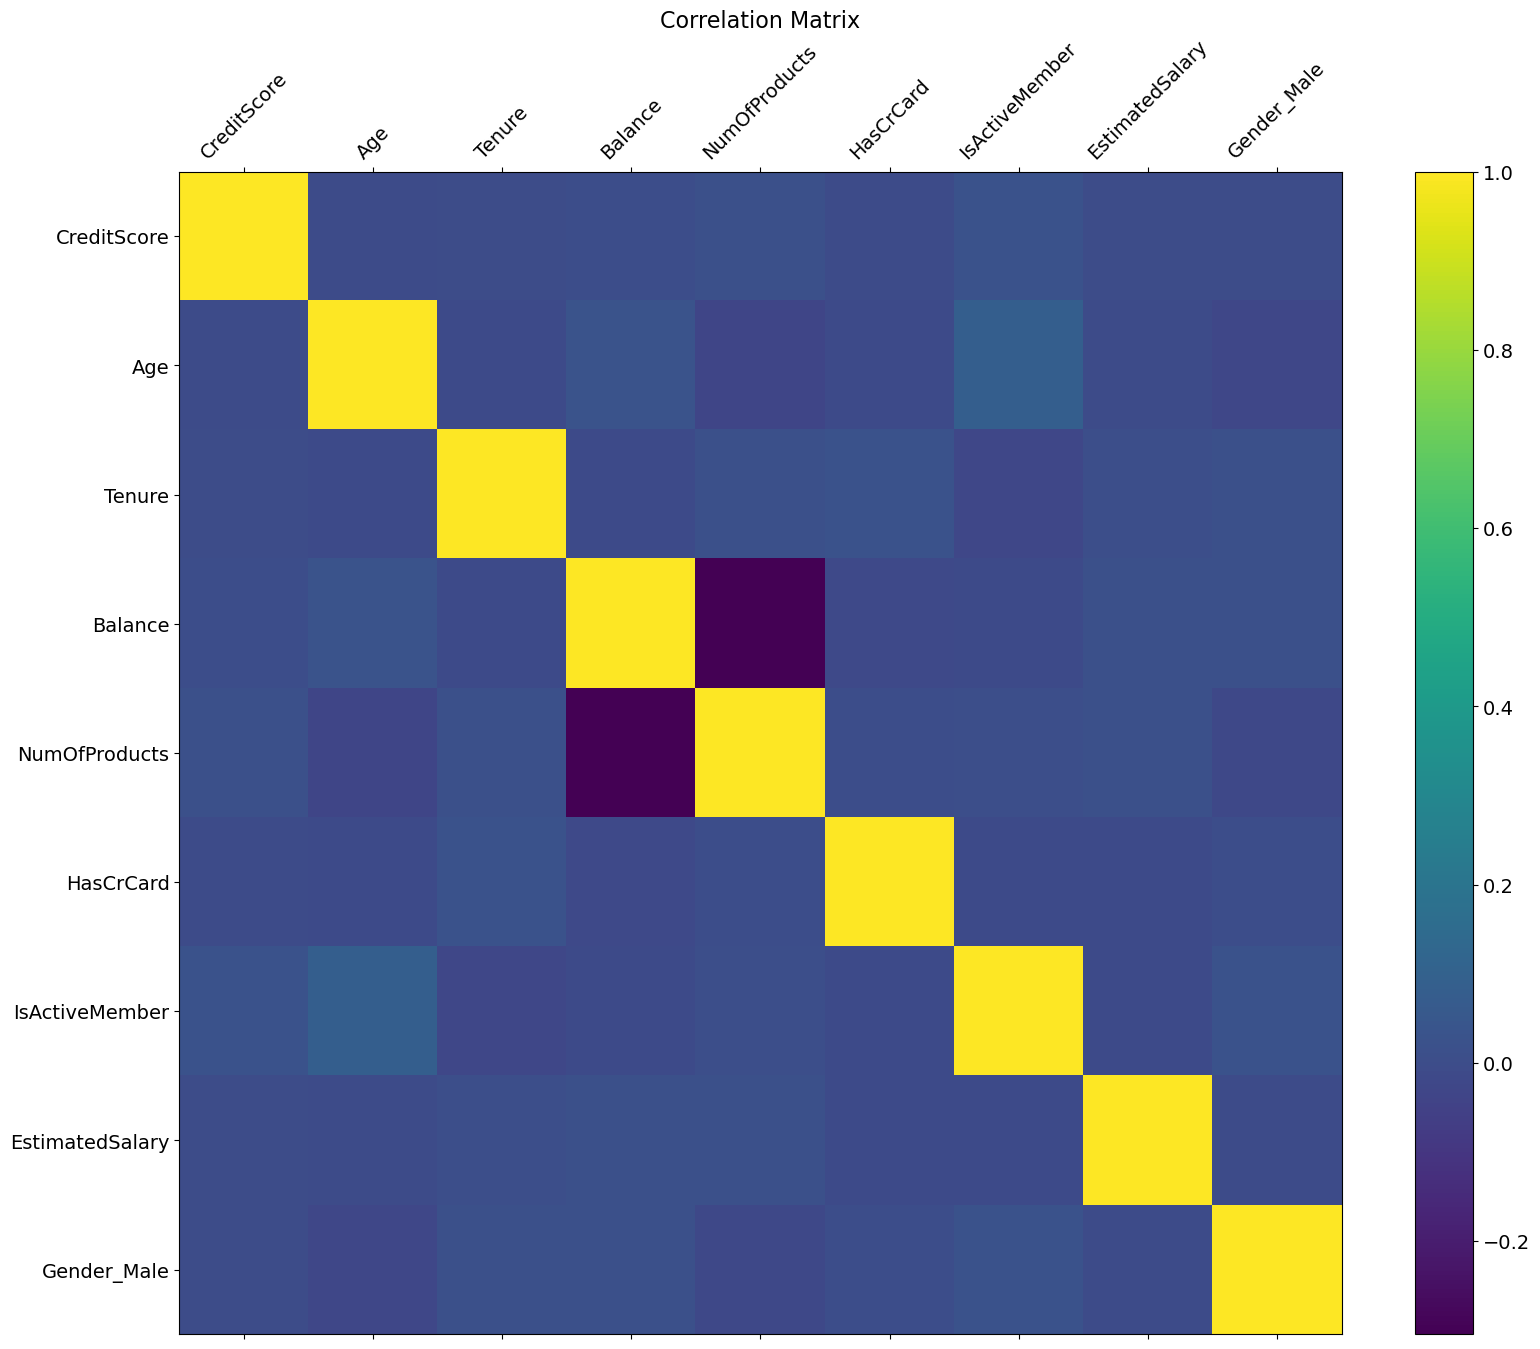

In [12]:
trialPredictors = predictors.drop(columns=['Geography_France', 'Geography_Spain'])
cf.correlationMatrix(trialPredictors)

Better still! Geography may have been too closely linked to Balance altogether; we will try training the model without it.

In [13]:
featureNames = predictors.columns
featureNames

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

## 4. Model Selection  

We will consider the following six alternative models:

1. **Logistic Regression**:
  * A simple yet interpretable model.
  * Suitable for binary classification tasks.
  * May need input data converted to categorical (e.g., one-hot encoding for categorical features like gender, education level).

2. **Random Forest**:
  * Ensemble method combining multiple decision trees.
  * Handles non-linear relationships.
  * Can handle both numerical and categorical features.

3. **K-Nearest Neighbours**:
  * KNN is easy to understand and implement.
  * It doesn’t make any underlying assumptions about the data distribution.
  * Can learn nonlinear decision boundaries.

4. **Gradient Boosting (e.g., XGBoost)**:
  * Powerful ensemble model.
  * Handles complex interactions.
  * Automatically handles missing values.
  * May not require explicit one-hot encoding.

5. **Support Vector Machine**:
  * SVC works well when there is a clear margin of separation between classes.
  * Aims to find the optimal hyperplane that maximizes the distance between data points of different classes.

6. **Neural Networks (Deep Learning)**:
  * Complex model capable of learning intricate patterns.
  * Requires substantial data and computational resources.
  * Can handle both numerical and categorical features.

## 5. Performance Metrics  

Choose appropriate metrics to compare model performance. Given that we are predicting the minority class representing approximately 20% of the data, we are interested in:

* **Precision**: Proportion of true positive predictions among all positive predictions.
* **Recall (Sensitivity)**: Proportion of actual positives correctly predicted.
* **F1-Score**: Harmonic mean of precision and recall.

## 6. Model Training and Evaluation  

* Split data into training and hold-out validation sets.
* Tune hyperparameters (e.g., learning rate, tree depth) using full grid search and randomised grid search for comparison, with cross-validation. It was decided after consultation that the only models requiring full optimisation were the K-Nearest Neighbour and Gradient Boosting models. For programming convenience, all other models were 'optimised' through the same python module, but with a single value specified for each hperparameter; this allowed the benefitof the GridSearchCV and RandomizedSearchCV outputs to be obtained for all models.
* Train each model with stratified k-fold cross-validation using the chosen features.
* Evaluate models using the selected performance metrics on the hold-out set.

In [ ]:
# Initial attept totune FNN hyperparameters before full training alongside other models
FNNresults= cf.trainFNNOnly(trialPredictors, outcomes, nEpochs=10, learningRate=0.0001, display=True, threshold=0.24)

Number of training positives: 1630
Number of validation positives: 407
Processing Logistic model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__C': 1.0}
Number of actual positives: 407
Number of predicted positives: 850


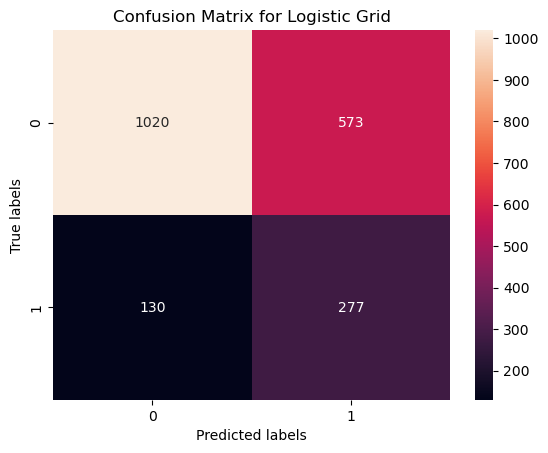

Random Search...


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__C': 1.0}
Number of actual positives: 407
Number of predicted positives: 850


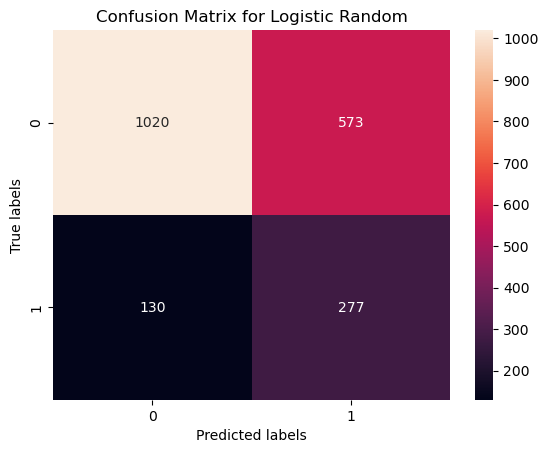

Processing KNN model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__n_neighbors': 3, 'regressor__weights': 'uniform'}
Number of actual positives: 407
Number of predicted positives: 278


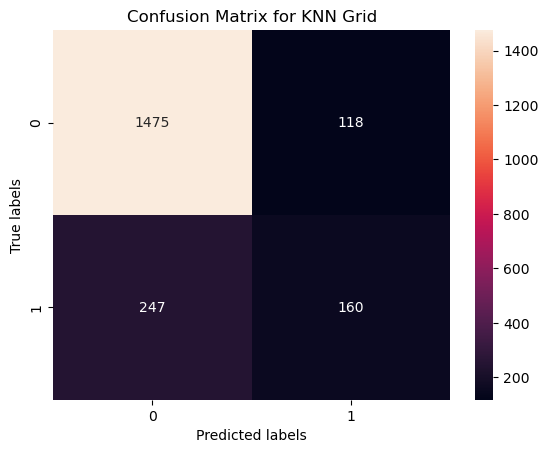

Random Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__weights': 'uniform', 'regressor__n_neighbors': 3}
Number of actual positives: 407
Number of predicted positives: 278


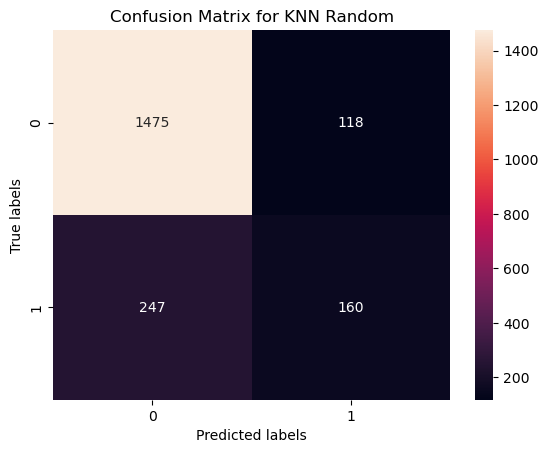

Processing Forest model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}
Number of actual positives: 407
Number of predicted positives: 236


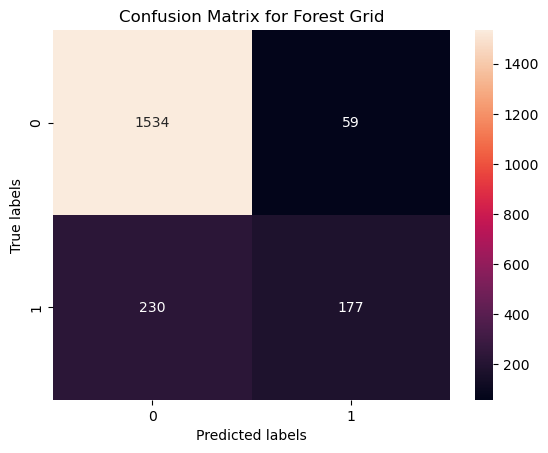

Random Search...


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__n_estimators': 100, 'regressor__max_depth': None}
Number of actual positives: 407
Number of predicted positives: 236


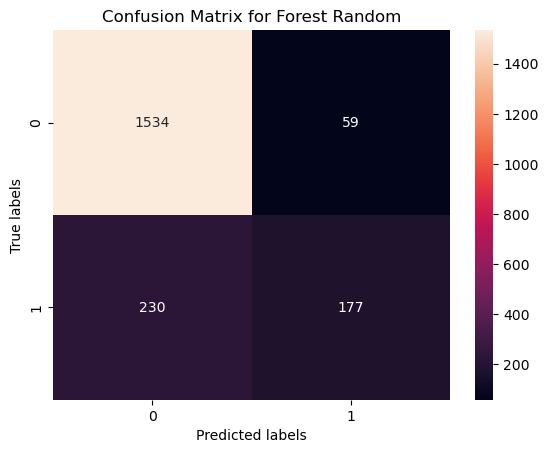

Processing Gradient model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__learning_rate': 1.0, 'regressor__max_depth': 20, 'regressor__n_estimators': 50}
Number of actual positives: 407
Number of predicted positives: 266


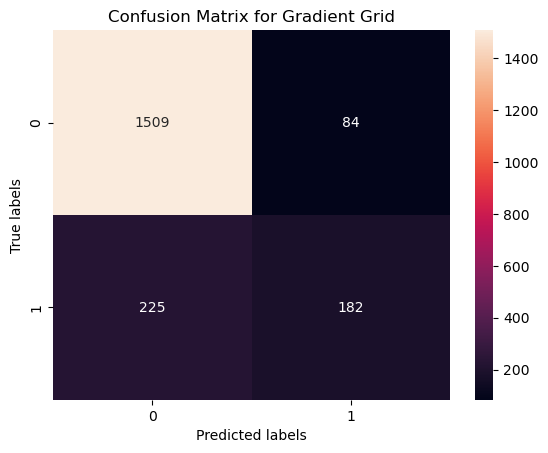

Random Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__n_estimators': 200, 'regressor__max_depth': None, 'regressor__learning_rate': 1.0}
Number of actual positives: 407
Number of predicted positives: 275


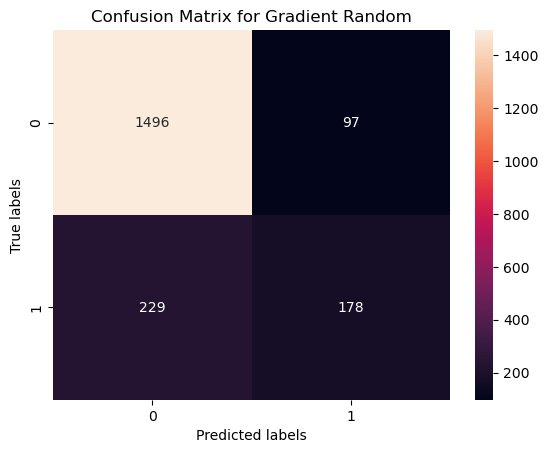

Processing SVC model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__C': 1.0, 'regressor__degree': 2, 'regressor__kernel': 'rbf'}
Number of actual positives: 407
Number of predicted positives: 1274


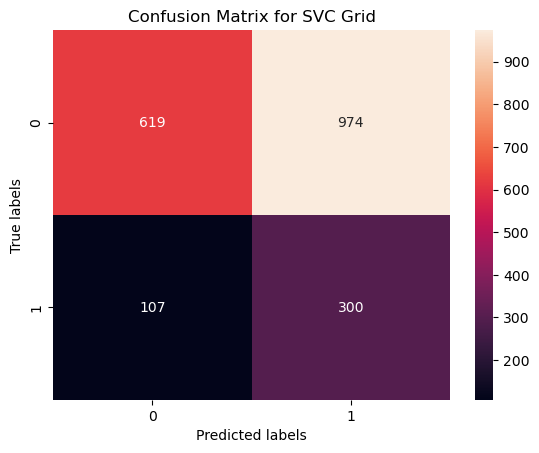

Random Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__kernel': 'rbf', 'regressor__degree': 2, 'regressor__C': 1.0}
Number of actual positives: 407
Number of predicted positives: 1274


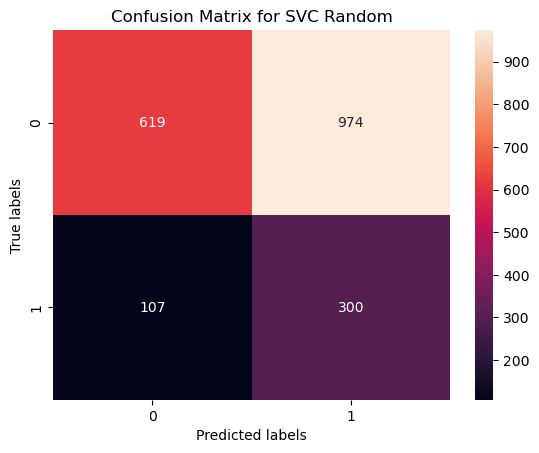

Epoch [1/10] - Loss: 0.5013
Epoch [2/10] - Loss: 0.4980
Epoch [3/10] - Loss: 0.3599
Epoch [4/10] - Loss: 0.5605
Epoch [5/10] - Loss: 0.3081
Epoch [6/10] - Loss: 0.5282
Epoch [7/10] - Loss: 0.4000
Epoch [8/10] - Loss: 0.4838
Epoch [9/10] - Loss: 0.4192
Epoch [10/10] - Loss: 0.5589
Model saved successfully!
F1 Score on Validation Data: 0.2594
ROC_AUC Score on Validation Data: 0.5364
Number of actual positives: 407
Number of predicted positives: 395


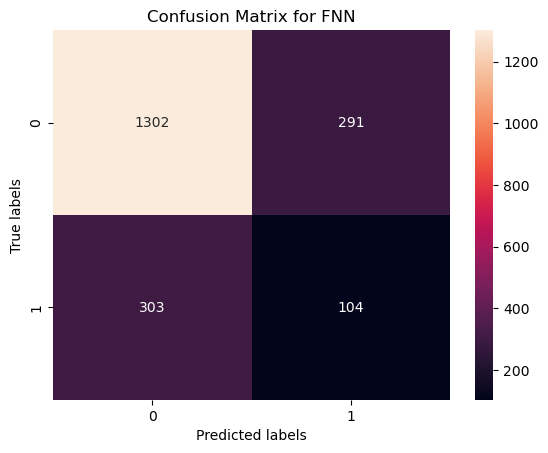

In [14]:
results, X_val, y_val = cf.trainTestCycle(trialPredictors,outcomes, stratifiedKF=True, threshold=0.23)

In [23]:
f1_val_scores = []
f1_train_scores = []
f1_scores= []
confusion_matrices = []
labels = []
for model, data in results.items():
    if model != 'FNN':
        # confusion matrix
        confusion_matrices.append(data['Grid']['validation']['confusion'])
        confusion_matrices.append(data['Random']['validation']['confusion'])
        # Best training scores
        f1_train_scores.append(data['Grid']['bestScore'])
        f1_train_scores.append(data['Random']['bestScore'])
        # validation scores
        f1_val_scores.append(data['Grid']['validation']['f1'])
        labels.append(model + '_grid')
        f1_val_scores.append(data['Random']['validation']['f1'])
        labels.append(model + '_rand')
        # data for plots
        f1_scores.append([data['Grid']['bestScore'],data['Grid']['validation']['f1']])
        f1_scores.append([data['Random']['bestScore'],data['Random']['validation']['f1']])
    else:
        # confusion matrix
        confusion_matrices.append(data['confusion'])
        # Best training scores
        f1_train_scores.append(0)
        # validation scores
        f1_val_scores.append(data['scores']['f1'])
        labels.append(model)
        # data for plots
        f1_scores.append([0, data['scores']['f1']])
print(labels)
print(f1_scores)

['Logistic_grid', 'Logistic_rand', 'KNN_grid', 'KNN_rand', 'Forest_grid', 'Forest_rand', 'Gradient_grid', 'Gradient_rand', 'SVC_grid', 'SVC_rand', 'FNN']
[[0.4393499172513626, 0.4407319013524264], [0.4393499172513626, 0.4407319013524264], [0.4820719087988531, 0.46715328467153283], [0.4820719087988531, 0.46715328467153283], [0.5392631194653218, 0.5505443234836704], [0.5392631194653218, 0.5505443234836704], [0.535092038863555, 0.5408618127786033], [0.5287347555857013, 0.5219941348973607], [0.3656471581075262, 0.3569303985722784], [0.3656471581075262, 0.3569303985722784], [0, 0.259351620947631]]


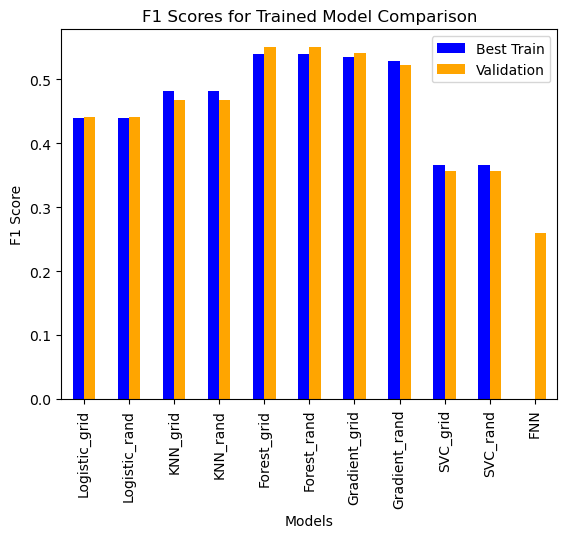

In [31]:
names =['Best Train', 'Validation']
colours = ['blue', 'orange']
# Create a DataFrame
df = pd.DataFrame(f1_scores, index=labels, columns=names)

# Plot the bar chart
ax = df.plot.bar(color=colours)
ax.set_title("F1 Scores for Trained Model Comparison")
ax.set_xlabel("Models")  # Customize x-axis label
ax.set_ylabel("F1 Score")  # Customize y-axis label
plt.savefig('F1_Comparison.png')
plt.show()

In [32]:
results['Forest']['Grid']['bestParams']

{'regressor__max_depth': None, 'regressor__n_estimators': 100}

In [15]:
results

{'Logistic': {'Grid': {'bestParams': {'regressor__C': 1.0},
   'bestEstimator': Pipeline(steps=[('regressor',
                    LogisticRegression(class_weight='balanced', random_state=42))]),
   'CVResults': {'mean_fit_time': array([0.08623657]),
    'std_fit_time': array([0.00788062]),
    'mean_score_time': array([0.01008596]),
    'std_score_time': array([0.00788062]),
    'param_regressor__C': masked_array(data=[1.0],
                 mask=[False],
           fill_value='?',
                dtype=object),
    'params': [{'regressor__C': 1.0}],
    'split0_test_score': array([0.45010183]),
    'split1_test_score': array([0.44334975]),
    'split2_test_score': array([0.44510978]),
    'split3_test_score': array([0.43098312]),
    'split4_test_score': array([0.4272051]),
    'mean_test_score': array([0.43934992]),
    'std_test_score': array([0.00874389]),
    'rank_test_score': array([1])},
   'bestScore': 0.4393499172513626,
   'duration': 5.4346394538879395,
   'cross_val_score'

Number of training positives: 1630
Number of validation positives: 407
Processing Logistic model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__C': 1.0}
Number of actual positives: 407
Number of predicted positives: 850


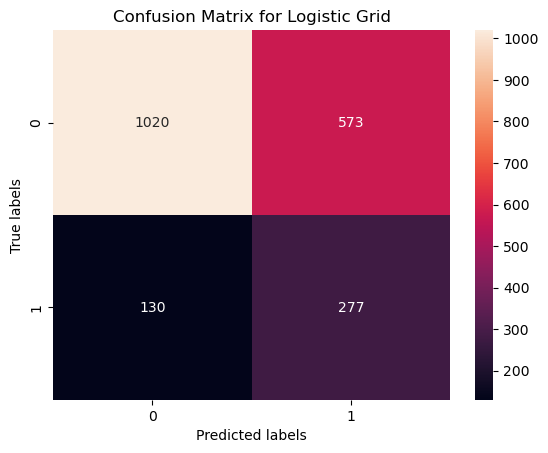

Random Search...


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__C': 1.0}
Number of actual positives: 407
Number of predicted positives: 850


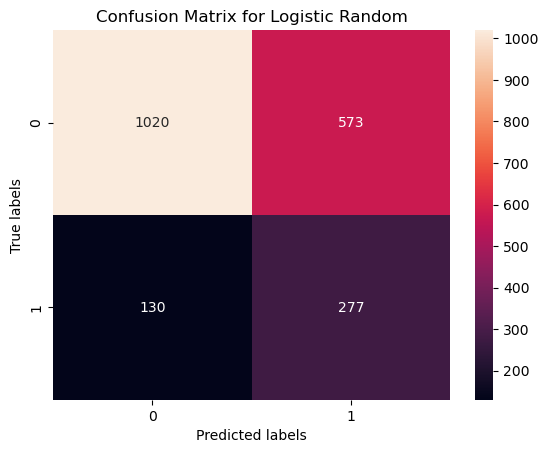

Processing KNN model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__n_neighbors': 4, 'regressor__weights': 'distance'}
Number of actual positives: 407
Number of predicted positives: 293


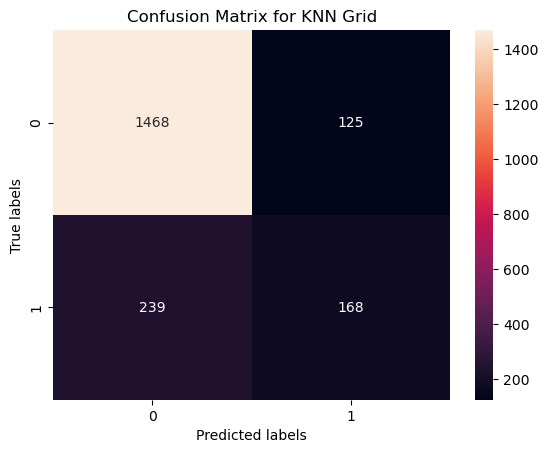

Random Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__weights': 'distance', 'regressor__n_neighbors': 5}
Number of actual positives: 407
Number of predicted positives: 234


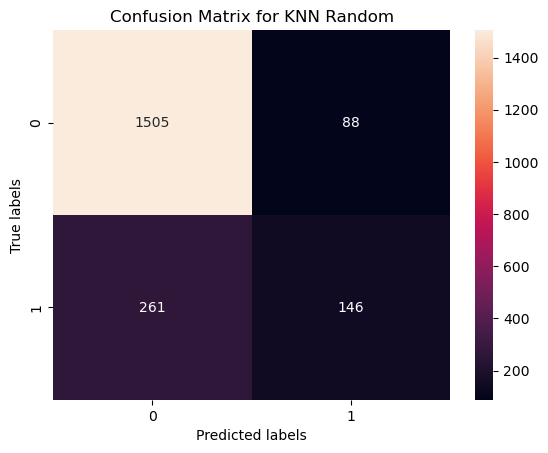

Processing Forest model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}
Number of actual positives: 407
Number of predicted positives: 238


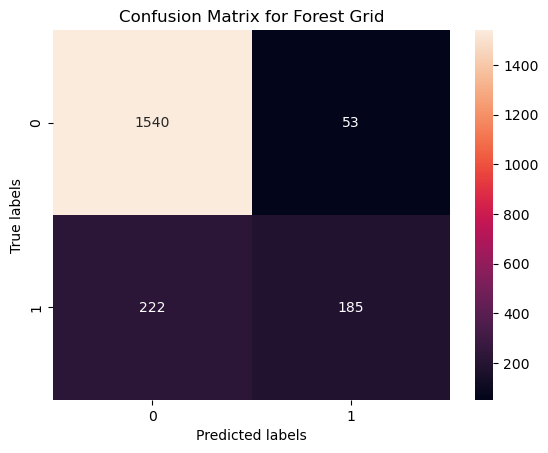

Random Search...


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__n_estimators': 100, 'regressor__max_depth': None}
Number of actual positives: 407
Number of predicted positives: 238


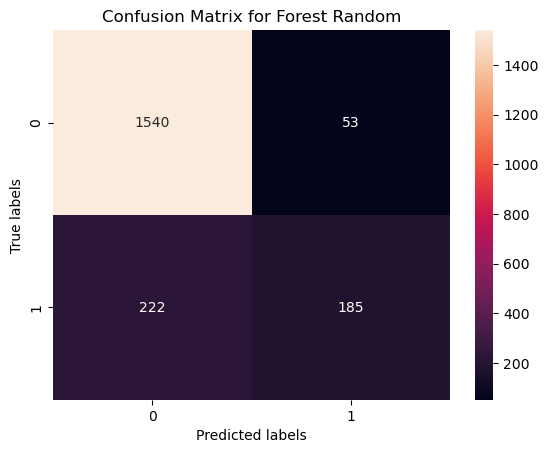

Processing Gradient model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__learning_rate': 0.5, 'regressor__max_depth': None, 'regressor__n_estimators': 50}
Number of actual positives: 407
Number of predicted positives: 263


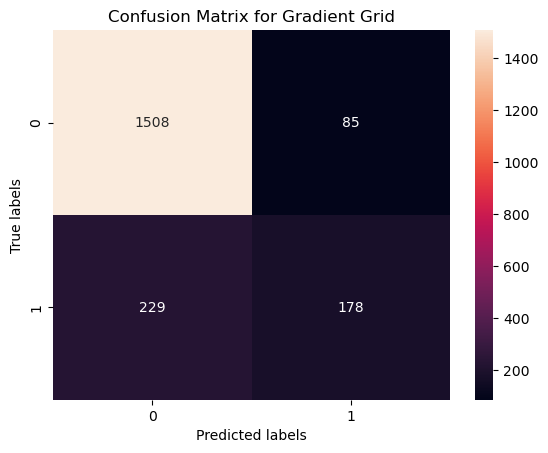

Random Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__n_estimators': 200, 'regressor__max_depth': None, 'regressor__learning_rate': 1.0}
Number of actual positives: 407
Number of predicted positives: 297


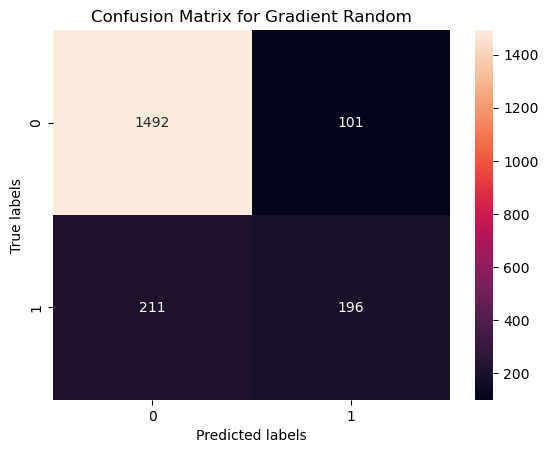

Processing SVC model:
Grid Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__C': 1.0, 'regressor__degree': 2, 'regressor__kernel': 'rbf'}
Number of actual positives: 407
Number of predicted positives: 1274


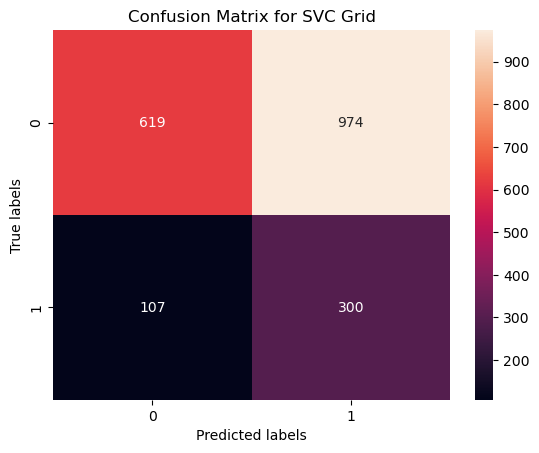

Random Search...
Number of training positives: 1630
Number of validation positives: 407
Best Hyperparameters: {'regressor__kernel': 'rbf', 'regressor__degree': 2, 'regressor__C': 1.0}
Number of actual positives: 407
Number of predicted positives: 1274


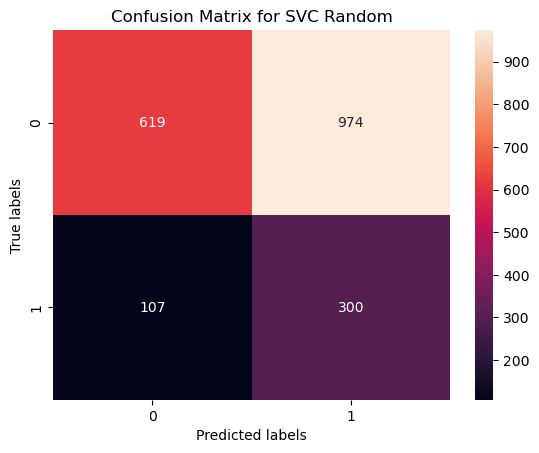

Epoch [1/10] - Loss: 0.4824
Epoch [2/10] - Loss: 0.2219
Epoch [3/10] - Loss: 0.4563
Epoch [4/10] - Loss: 0.4752
Epoch [5/10] - Loss: 0.4766
Epoch [6/10] - Loss: 0.4475
Epoch [7/10] - Loss: 0.4769
Epoch [8/10] - Loss: 0.6926
Epoch [9/10] - Loss: 0.5636
Epoch [10/10] - Loss: 0.7567
Model saved successfully!
F1 Score on Validation Data: 0.3091
ROC_AUC Score on Validation Data: 0.5457
Number of actual positives: 407
Number of predicted positives: 680


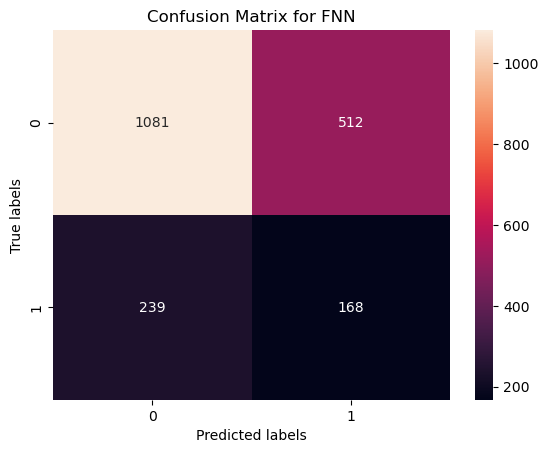

In [13]:
resultsFullData, X_val3, y_val3 = cf.trainTestCycle(predictors,outcomes, stratifiedKF=True, threshold=0.23)

In [ ]:
otherResults, X_val2, y_val2 = cf.trainTestCycle(trialPredictors,outcomes, stratifiedKF=True, threshold=0.23)

In [ ]:
print(FNNresults)

In [ ]:
results

In [ ]:
results['Logistic']['Grid']['validation']['confusion']

In [ ]:
tn, fp, fn, tp = results['Logistic']['Grid']['validation']['confusion'].ravel()
print(tn)
print(fp)
print(fn)
print(tp)